<a href="https://colab.research.google.com/github/Nasrin-Akhtar/Datascience-_domain_jobs_salary_prediction/blob/main/datascience_salary_prediction2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing required libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge,LinearRegression
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import Normalizer, StandardScaler






import warnings
warnings.filterwarnings('ignore')
import requests





# 2. Data Cleaning and Preprocessing


In [4]:
df=pd.read_csv('/.~ds_salaries.csv')
#df=pd.read_csv('/kaggle/input/data-science-salaries-2023/ds_salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#df_country=pd.read_csv('/kaggle/input/country-code-access-file/all.csv')
df_country=pd.read_csv('/country_code.csv')
df_country.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [7]:
df_country.shape

(249, 11)

In [8]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

***Hence, there is no missing values in our dataset***

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


**So, we got 4 numerical features and 7 categorical features. Now let's modify our dataset a little bit.**



In [10]:
country_dict= dict(zip(df_country['alpha-2'],df_country['name']))
df['employee_residence']= df['employee_residence'].map(country_dict)
df['company_location']=df['company_location'].map(country_dict)


**Firstly, to make it easy to understand, converting the country_codes to country_name**

In [11]:
print(df['experience_level'].unique())


['SE' 'MI' 'EN' 'EX']


In [12]:
df['experience_level']=df['experience_level'].replace({'SE':'Senior','MI':'Mid-level','EN':'Entry','EX':'Executive'})


In [13]:
print(df['employment_type'].unique())


['FT' 'CT' 'FL' 'PT']


In [14]:
df['employment_type']=df['employment_type'].replace({'FT':'Full-Time','CT':'Contractual','FL':'Freelance','PT':'Part-time'})


In [15]:
print(df['company_size'].unique())


['L' 'S' 'M']


In [16]:
df['company_size']=df['company_size'].replace({'L':'Large','S':'Small','M':'Mid-cap'})


In [17]:
df['salary_currency'].unique()

array(['EUR', 'USD', 'INR', 'HKD', 'CHF', 'GBP', 'AUD', 'SGD', 'CAD',
       'ILS', 'BRL', 'THB', 'PLN', 'HUF', 'CZK', 'DKK', 'JPY', 'MXN',
       'TRY', 'CLP'], dtype=object)

**We can see there are 20 different currencies found here in the dataset**

In [18]:
df['remote_ratio'].unique()

array([100,   0,  50])

In [19]:
df['remote_ratio']=df['remote_ratio'].replace({100:'Fully_remote',50:'Partially_remote',0:'On-site'})


**Converting the feature remote_ratio in categorical terms for our analysing ease**

In [20]:
job_list=[df['job_title'].unique()]
print(job_list)

[array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning S

In [21]:
df.loc[df['job_title'].str.contains('Scientist'), 'job_title'] = 'Data Scientist'
df.loc[df['job_title'].str.contains('Analyst'),'job_title']='Data Analyst'
df.loc[df['job_title'].str.contains('Engineer'),'job_title']='Data Engineer'
df.loc[df['job_title'].str.contains('Manager'),'job_title']='Data Manager'
df.loc[df['job_title'].str.contains('Lead'),'job_title']='Data Lead'

**We have clubbed the various job titles which are similar by role different by names, to make better insights from it.**

In [22]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior,Full-Time,Data Scientist,80000,EUR,85847,Spain,Fully_remote,Spain,Large
1,2023,Mid-level,Contractual,Data Engineer,30000,USD,30000,United States of America,Fully_remote,United States of America,Small
2,2023,Mid-level,Contractual,Data Engineer,25500,USD,25500,United States of America,Fully_remote,United States of America,Small
3,2023,Senior,Full-Time,Data Scientist,175000,USD,175000,Canada,Fully_remote,Canada,Mid-cap
4,2023,Senior,Full-Time,Data Scientist,120000,USD,120000,Canada,Fully_remote,Canada,Mid-cap


**Hence, this is our final dataset after cleaning**

***After cleaning or modifying lets move on to the next section***

# 3. Summary Statistics

In [23]:
def summary(df):
    df.shape
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} observations.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Types"] = df.dtypes
    return summary
summary(df)

Dataset has 11 features and 3755 observations.


,Unique,Missing,Types
work_year,4,0,int64
experience_level,4,0,object
employment_type,4,0,object
job_title,30,0,object
salary,815,0,int64
salary_currency,20,0,object
salary_in_usd,1035,0,int64
employee_residence,78,0,object
remote_ratio,3,0,object
company_location,72,0,object


In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
work_year,3755.0,2022.373635,0.691448,2020.0,2022.0,2022.0,2023.0,2023.0
salary,3755.0,190695.571771,671676.500508,6000.0,100000.0,138000.0,180000.0,30400000.0
salary_in_usd,3755.0,137570.389880,63055.625278,5132.0,95000.0,135000.0,175000.0,450000.0


This is the matrix representation of the numerical features provided in the data, from where we can see the **mean, median, quantiles, max, min, standard deviation and frequencies.**
As, we can see **mean for the features are greater than median** hence distributions should be **positively skewed**

# **4. Frequency Distribution and UNIVARIATE PLOTTING**

skew        0.536401
kurtosis    0.834006
Name: salary_in_usd, dtype: float64


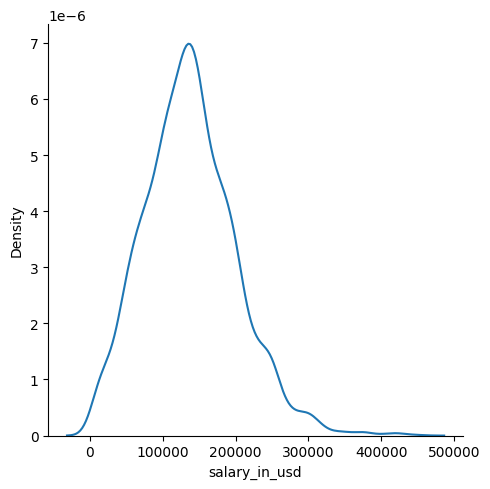

In [25]:
sns.displot(df['salary_in_usd'],kind='kde')
print(df['salary_in_usd'].agg(['skew','kurtosis']))
#check normality

Here, it is clear from the plot that the assumption we made before was correct and the distribution of salary is **positively skewed with skewness 0.536**   and as **kurtosis is positive** that is ***0.83*  which is less than 3 i.e normal distribution** which implies it is **platykurtic implies has thinner tails and less peaked**

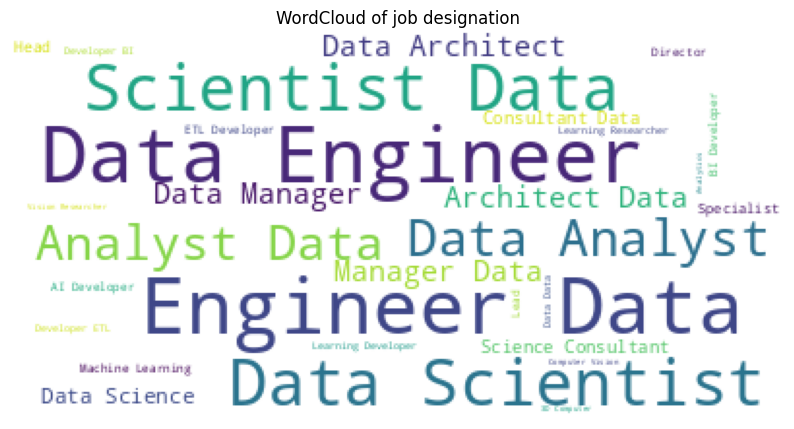

In [26]:
wordCloud = WordCloud(
    background_color='white',
    max_font_size = 40).generate(' '.join(df.job_title))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wordCloud)
plt.title('WordCloud of job designation')
plt.show()


In [27]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [28]:
selected_columns=['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence',
       'remote_ratio','company_location', 'company_size']

def univariate_plotting(df):
    for item in selected_columns:
        unique_value=df[item].nunique()
        if df[item].dtypes!='int64' and unique_value<6:
            dummy_df=df[item].value_counts()
            fig=px.pie(dummy_df,names=dummy_df.index,values=dummy_df.values,title=f'Percentage of employees {item}')
            fig.update_layout(height=600,width=500)
            fig.show()
        elif unique_value < 70:
            fig=px.histogram(df,x=item,title=f'Graphical representation of {item}',color=item,nbins=30, text_auto=False)
            fig.update_layout(xaxis_title=item, yaxis_title='Frequency',height=600,width=800)
            fig.show()
        else:
            dummy_df=df[item].value_counts()[:50]
            fig=px.treemap(dummy_df,path = [dummy_df.index],values=dummy_df.values,title=f'Treemap representation of top 50 {item}')
            fig.update_layout(height=600,width=800)
            fig.show()
univariate_plotting(df)

**1. JOB frequency has been increased on yearly basis, and least found in the year of 2020 and 2021, Covid can be a reason behind the massive difference between the year 2020-'21 and the year 2022-'23 and can colnclude the job market is recovering also.**

**2. Around 67% of the working employees are at senior position where as Executive and freshers are very few.**


**3. 99% of the employees are working as Full-time.**

**4. Data Engineer jobs are in max numbers whereas Data Scientist jobs comes in 2nd position**

**5. As most of the salaries are in usd, reason can be most of the job location at United states.**


**6. Most of the employees are from US, India comes on 5th**

**7. The increase in remote working (48.8%) and on-site working (51.2%) may have been influenced by the COVID-19 pandemic, which prompted many organizations to adopt remote work arrangements to ensure safety and business continuity.**

**8. 84% of workers are contributing to mid-sized companies, likely reflecting the robust growth and opportunities within this sector.**

# **5. Bivariate Analysis**

**> 1.  Salary Analysis**


In [29]:
def bivariate_plotting(df):
    selected_columns=['work_year', 'employment_type', 'job_title',
       'remote_ratio','company_location', 'company_size']
    for item in selected_columns:
        unique_values=df[item].nunique()
        if unique_values>15:
            dummy_df=df.groupby([item])['salary_in_usd'].mean()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,title=f'Salaries with respect to {item}')
            #fig.add_trace(go.Scatter(x = dummy_df.index, y = dummy_df.values, mode="markers+lines",name = 'Trend Line',line=dict( color='blue')))
            fig.update_layout(height=600,width=800)
            fig.show()
        elif unique_values<70:
            dummy_df=df.groupby([item])['salary_in_usd'].mean()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Salaries with respect to {item}')
            #fig.add_trace(go.Scatter(x = dummy_df.index, y = dummy_df.values, mode="markers+lines",name = 'Trend Line',line=dict( color='blue')))
            fig.update_layout(height=600,width=800)
            fig.show()
        else:
            dummy_df=df.sort_values(by='salary_in_usd').groupby([item])['salary_in_usd'].mean()[-15:]
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Salaries with respect to {item}')
            #fig.add_trace(go.Scatter(x = dummy_df.index, y = dummy_df.values, mode="markers+lines",name = 'Trend Line',line=dict( color='blue')))
            fig.update_layout(height=600,width=800)
            fig.show()

bivariate_plotting(df)

> **>2. Experience level Analysis**

In [30]:
selected_columns=['job_title','company_size','remote_ratio']
for item in selected_columns:
    exp_job = df.groupby(['experience_level',item]).size()
    entry_top5 = exp_job['Entry'].sort_values(ascending = False)[:5]
    executive_top5 = exp_job['Executive'].sort_values(ascending = False)[:5]
    mid_top5 = exp_job['Mid-level'].sort_values(ascending = False)[:5]
    senior_top5 = exp_job['Senior'].sort_values(ascending = False)[:5]
    fig = go.Figure(data=[
        go.Bar(name = 'Entry', x = entry_top5.index,
           y=entry_top5.values, text = entry_top5.values),
        go.Bar(name = 'Executive', x = executive_top5.index,
           y = executive_top5.values, text = executive_top5.values),
        go.Bar(name = 'Mid-level', x = mid_top5.index,
           y = mid_top5.values, text = mid_top5.values ),
        go.Bar(name = 'Senior', x = senior_top5.index,
           y = senior_top5.values, text = senior_top5.values)])
    fig.show()

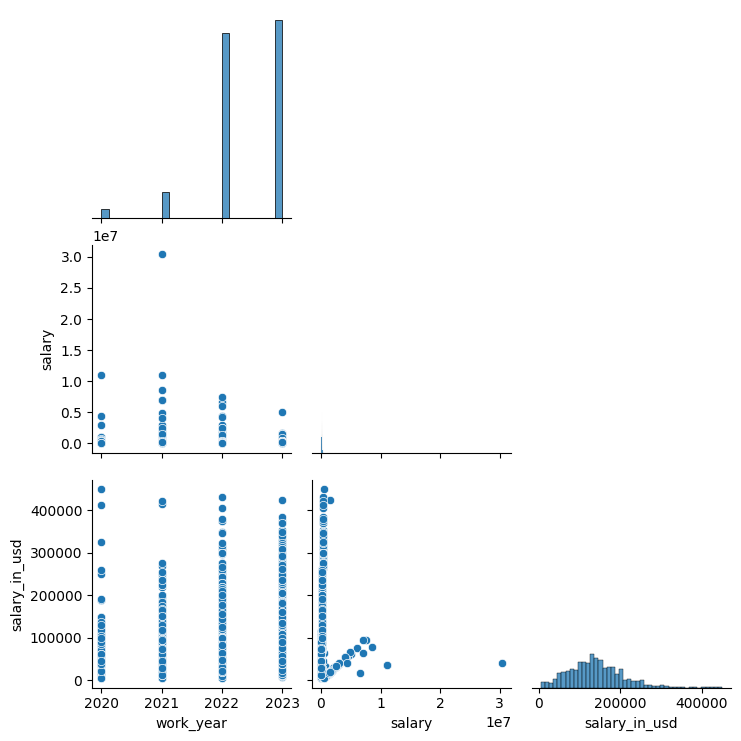

In [31]:
sns.pairplot(df,corner=True,aspect=True)

In [32]:
year_2020=df[df.work_year==2020]
year_2021=df[df.work_year==2021]
year_2022=df[df.work_year==2022]
year_2023=df[df.work_year==2023]
# splitting dataset based on working years

In [33]:
fig = px.box(df['work_year'], y=df['salary_in_usd'], points="all", notched=True)
fig.show()

**Median salary is 135k USD and there is many outliers according the box plot So, we 'll remove those to get a better prediction result**

In [34]:
Q1=np.percentile(df['salary_in_usd'],25)
Q3=np.percentile(df['salary_in_usd'],75)
IQR=Q3-Q1
upper=np.where(df['salary_in_usd']>=(Q3+1.5*IQR))
lower=np.where(df['salary_in_usd']<=(Q1-1.5*IQR))
new_df=df.reset_index(drop=True)
new_df.drop(upper[0],inplace= True)
new_df.shape

(3692, 11)

# 6.Outlier Detection

In [35]:
px.box(new_df, x=new_df['work_year'], y=new_df['salary_in_usd'],color=new_df['work_year'])

In [36]:
#YEAR_2020
Q1=np.percentile(year_2020['salary_in_usd'],25)
Q3=np.percentile(year_2020['salary_in_usd'],75)
IQR=Q3-Q1
upper=np.where(year_2020['salary_in_usd']>=(Q3+1.5*IQR))
lower=np.where(year_2020['salary_in_usd']<=(Q1-1.5*IQR))
year_2020=year_2020.reset_index(drop=True)
year_2020.drop(upper[0],inplace= True)
year_2020.shape
#YEAR_2021
Q1=np.percentile(year_2021['salary_in_usd'],25)
Q3=np.percentile(year_2021['salary_in_usd'],75)
IQR=Q3-Q1
upper=np.where(year_2021['salary_in_usd']>=(Q3+1.5*IQR))
lower=np.where(year_2021['salary_in_usd']<=(Q1-1.5*IQR))
year_2021=year_2021.reset_index(drop=True)
year_2021.drop(upper[0],inplace= True)
year_2021.shape

(225, 11)

**All kind of outliers has been discarded**

# **7. Normality check**

0.9939595460891724 2.721440260644581e-11


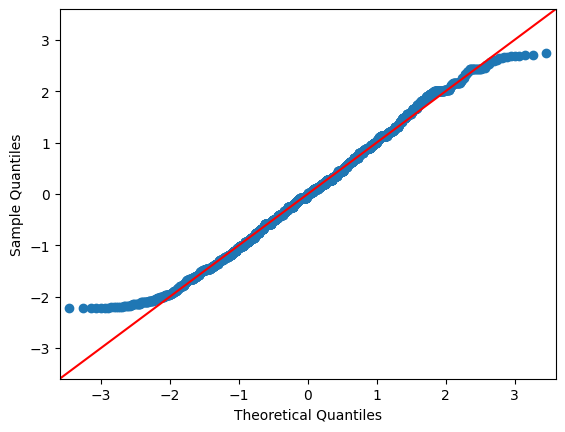

In [37]:
test_stat,p_value= stats.shapiro(new_df['salary_in_usd'])
print(test_stat,p_value)
sm.qqplot(new_df['salary_in_usd'],line='45', fit=True,dist=stats.norm)
py.show()

In [38]:
new_df['salary_in_usd']=np.log(new_df['salary_in_usd'])

**As p value according shapiro wilk test is less than 0.05, hence it doesn't follow normal distribution so, we have convert it using logarithmic transformation**

# **7. Feature Engineering**

In [39]:
categorical_col=['experience_level','employment_type','remote_ratio','company_size','job_title','company_location','employee_residence']

In [40]:
dummy=pd.get_dummies(new_df[categorical_col],drop_first=True,dtype=int)
print(dummy)

      experience_level_Executive  experience_level_Mid-level  \
0                              0                           0   
1                              0                           1   
2                              0                           1   
3                              0                           0   
4                              0                           0   
...                          ...                         ...   
3749                           0                           0   
3751                           0                           1   
3752                           0                           0   
3753                           0                           0   
3754                           0                           0   

      experience_level_Senior  employment_type_Freelance  \
0                           1                          0   
1                           0                          0   
2                           0                      

**Encoded the categorical variables using dummy encoding**

In [41]:
con_col=new_df[['salary_in_usd','work_year']]
dummy_df=pd.concat([con_col,dummy],axis=1)
dummy_df.head()

,salary_in_usd,work_year,experience_level_Executive,experience_level_Mid-level,experience_level_Senior,employment_type_Freelance,employment_type_Full-Time,employment_type_Part-time,remote_ratio_On-site,remote_ratio_Partially_remote,...,employee_residence_Switzerland,employee_residence_Thailand,employee_residence_Tunisia,employee_residence_Turkey,employee_residence_Ukraine,employee_residence_United Arab Emirates,employee_residence_United Kingdom of Great Britain and Northern Ireland,employee_residence_United States of America,employee_residence_Uzbekistan,employee_residence_Viet Nam
0,11.360322,2023,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.308953,2023,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,10.146434,2023,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,12.072541,2023,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.695247,2023,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**This is the final dataset after encodings**

In [42]:
def make_mi_scores(X,Y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname]= X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X,Y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores,name="MI Scores",index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [43]:
X=dummy_df.copy()
y=X.pop('salary_in_usd')
mi_scores= make_mi_scores(X,y)

In [45]:
mm=mi_scores.sort_values(ascending=True)
print(mi_scores.sort_values(ascending=True))

selected_columns = mi_scores[mi_scores > 0].index

X_new=dummy_df[selected_columns]
X_new.head()
X_new.shape
#mutual info regressor score to check dependency

company_location_Bahamas                       0.000000
employee_residence_Slovakia                    0.000000
employee_residence_North Macedonia             0.000000
company_location_China                         0.000000
employee_residence_Serbia                      0.000000
                                                 ...   
remote_ratio_On-site                           0.115142
work_year                                      0.142862
experience_level_Senior                        0.182845
company_location_United States of America      0.242988
employee_residence_United States of America    0.256648
Name: MI Scores, Length: 187, dtype: float64


(3692, 114)

**Calculated mutual info regressor score between independent variables and dependent variable to check dependency**

In [46]:
dummy_df.corr()

,salary_in_usd,work_year,experience_level_Executive,experience_level_Mid-level,experience_level_Senior,employment_type_Freelance,employment_type_Full-Time,employment_type_Part-time,remote_ratio_On-site,remote_ratio_Partially_remote,...,employee_residence_Switzerland,employee_residence_Thailand,employee_residence_Tunisia,employee_residence_Turkey,employee_residence_Ukraine,employee_residence_United Arab Emirates,employee_residence_United Kingdom of Great Britain and Northern Ireland,employee_residence_United States of America,employee_residence_Uzbekistan,employee_residence_Viet Nam
salary_in_usd,1.000000,0.287598,0.098283,-0.258013,0.409719,-0.088604,0.201889,-0.174333,0.147645,-0.282908,...,-0.011350,-0.081466,-0.038098,-0.119649,-0.053454,-0.009799,-0.150265,0.596747,-0.005396,-0.069341
work_year,0.287598,1.000000,0.004382,-0.126304,0.194002,-0.050766,0.113448,-0.094676,0.290786,-0.280386,...,-0.005820,-0.001594,-0.008875,-0.051890,0.006117,-0.042939,-0.027920,0.294246,0.004324,-0.029157
experience_level_Executive,0.098283,0.004382,1.000000,-0.087756,-0.237652,-0.008695,0.016557,-0.011348,0.002698,0.007339,...,-0.005495,-0.004758,-0.002746,-0.006144,-0.005495,-0.004758,-0.020099,0.013533,0.067823,-0.004758
experience_level_Mid-level,-0.258013,-0.126304,-0.087756,1.000000,-0.749128,0.035838,-0.034787,-0.006639,-0.021747,0.098278,...,0.022648,0.008074,-0.008657,0.052140,-0.017321,0.008074,0.253908,-0.263213,-0.012245,0.008074
experience_level_Senior,0.409719,0.194002,-0.237652,-0.749128,1.000000,-0.040983,0.112031,-0.096874,0.078384,-0.214838,...,-0.046908,-0.020405,-0.023444,-0.036790,0.005615,-0.000192,-0.211767,0.342516,-0.033160,-0.020405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
employee_residence_United Arab Emirates,-0.009799,-0.042939,-0.004758,0.008074,-0.000192,-0.001486,0.002830,-0.001940,-0.010188,-0.006568,...,-0.000939,-0.000813,-0.000469,-0.001050,-0.000939,1.000000,-0.006188,-0.056575,-0.000664,-0.000813
employee_residence_United Kingdom of Great Britain and Northern Ireland,-0.150265,-0.027920,-0.020099,0.253908,-0.211767,-0.011308,0.021531,-0.014757,0.010516,0.045638,...,-0.007146,-0.006188,-0.003571,-0.007990,-0.007146,-0.006188,1.000000,-0.430458,-0.005051,-0.006188
employee_residence_United States of America,0.596747,0.294246,0.013533,-0.263213,0.342516,-0.103389,0.148859,-0.124978,0.173794,-0.355280,...,-0.065336,-0.056575,-0.032655,-0.073058,-0.065336,-0.056575,-0.430458,1.000000,-0.046187,-0.056575
employee_residence_Uzbekistan,-0.005396,0.004324,0.067823,-0.012245,-0.033160,-0.001213,0.002310,-0.001583,-0.000555,-0.005362,...,-0.000767,-0.000664,-0.000383,-0.000857,-0.000767,-0.000664,-0.005051,-0.046187,1.000000,-0.000664


In [47]:
scaler=StandardScaler()
x_scaled = scaler.fit_transform(X_new)

**We have scaled data to ensure all features have a consistent scale, improving model training, convergence, and performance.**

#  **8. Training & Validation**

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.2,random_state=42)

In [49]:
models=[('LR',LinearRegression()),('XGB',XGBRegressor()),
       ('Lasso', Lasso()),
        ('Ridge', Ridge()),
        ('Elastic Net', ElasticNet()),
        ('Bayesian Ridge', BayesianRidge()),
        ('SVR', SVR()),
        ('Gradient Boosting', GradientBoostingRegressor())]
         # stackregressor

In [50]:

for name,model in models:
    pipeline = Pipeline([('model',model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,y_pred)
    R2_score=r2_score(y_test,y_pred)
    print( name, ":",rmse, R2_score)

LR : 633042507.2626153 -1.1450770399669699e+18
XGB : 0.40669155661763323 0.5273939540712795
Lasso : 0.5917801649170819 -0.0006674430185564795
Ridge : 0.3839895244234549 0.5786842309665563
Elastic Net : 0.5917801649170819 -0.0006674430185564795
Bayesian Ridge : 0.38422052963195746 0.5781771576939038
SVR : 0.6006117558380148 -0.03075777159616866
Gradient Boosting : 0.39130429812093365 0.5624797106663029


**r2_score is not good for the above models, Ridge regressor showing max among all i.e 0.57.
 Let's try out other ways to improve r2_score**

In [51]:
def stack_reg(base,meta):
    estimator=[
        (base),
        (meta)
    ]
    reg=StackingRegressor(estimators=estimator,final_estimator=GradientBoostingRegressor(random_state=42))
    reg.fit(X_train,y_train)
    y_pred=reg.predict(X_test)
    R2_score=r2_score(y_test,y_pred)
    return R2_score

In [52]:
stack_reg(('XGB',XGBRegressor()),('Ridge',Ridge()))

0.5539824755217553

In [53]:
stack_reg(('Bayesian Ridge', BayesianRidge()),('Gradient Boosting', GradientBoostingRegressor()))

0.5623049019202332

In [54]:
stack_reg(('XGB',XGBRegressor()),('Bayesian Ridge', BayesianRidge()))

0.5716837090250222

In [55]:
stack_reg(('Ridge',Ridge()),('Bayesian Ridge', BayesianRidge()))

0.5470099821727765

**Using stacking method to find better r2_score**

In [56]:
rd=Ridge(random_state=42)
params={
    'alpha':(0.001, 0.01, 0.1, 1.0, 10.0, 100.0)
}
mod3=GridSearchCV(rd, params, cv=5)
mod3.fit(X_train,y_train)
print('Best hyperparameter : ', mod3.best_params_)

Best hyperparameter :  {'alpha': 10.0}


In [57]:
y_pred = mod3.predict(X_test)
print(f'Train RMSE : {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R2_score : {r2_score(y_test, y_pred)}')

Train RMSE : 0.3826060506773192
R2_score : 0.5817146744654633


**after hypertuning using GridSearchCV method our r2_score has been improved**